In [37]:
import matplotlib.pyplot as plt
import copy
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler

In [38]:
from torchmetrics import MeanAbsolutePercentageError as MAPE

In [39]:
df = pd.read_csv("AirfoilSelfNoise.csv")
df.describe()

,f,alpha,c,U_infinity,delta,SSPL
count,1503.000000,1503.000000,1503.000000,1503.000000,1503.000000,1503.000000
mean,2886.380572,6.782302,0.136548,50.860745,0.011140,124.835943
std,3152.573137,5.918128,0.093541,15.572784,0.013150,6.898657
min,200.000000,0.000000,0.025400,31.700000,0.000401,103.380000
25%,800.000000,2.000000,0.050800,39.600000,0.002535,120.191000
50%,1600.000000,5.400000,0.101600,39.600000,0.004957,125.721000
75%,4000.000000,9.900000,0.228600,71.300000,0.015576,129.995500
max,20000.000000,22.200000,0.304800,71.300000,0.058411,140.987000


In [40]:
#Negative values check
df.lt(0).sum()

f             0
alpha         0
c             0
U_infinity    0
delta         0
SSPL          0
dtype: int64

In [41]:
#zeros check
(df == 0).sum()
#alpha being zero as it serves as angle of attack. 0 would equate to parallel flow

f               0
alpha         329
c               0
U_infinity      0
delta           0
SSPL            0
dtype: int64

In [42]:
#NAs check
df.isna().sum()

f             0
alpha         0
c             0
U_infinity    0
delta         0
SSPL          0
dtype: int64

array([[<AxesSubplot:title={'center':'f'}>,
        <AxesSubplot:title={'center':'alpha'}>],
       [<AxesSubplot:title={'center':'c'}>,
        <AxesSubplot:title={'center':'U_infinity'}>],
       [<AxesSubplot:title={'center':'delta'}>,
        <AxesSubplot:title={'center':'SSPL'}>]], dtype=object)

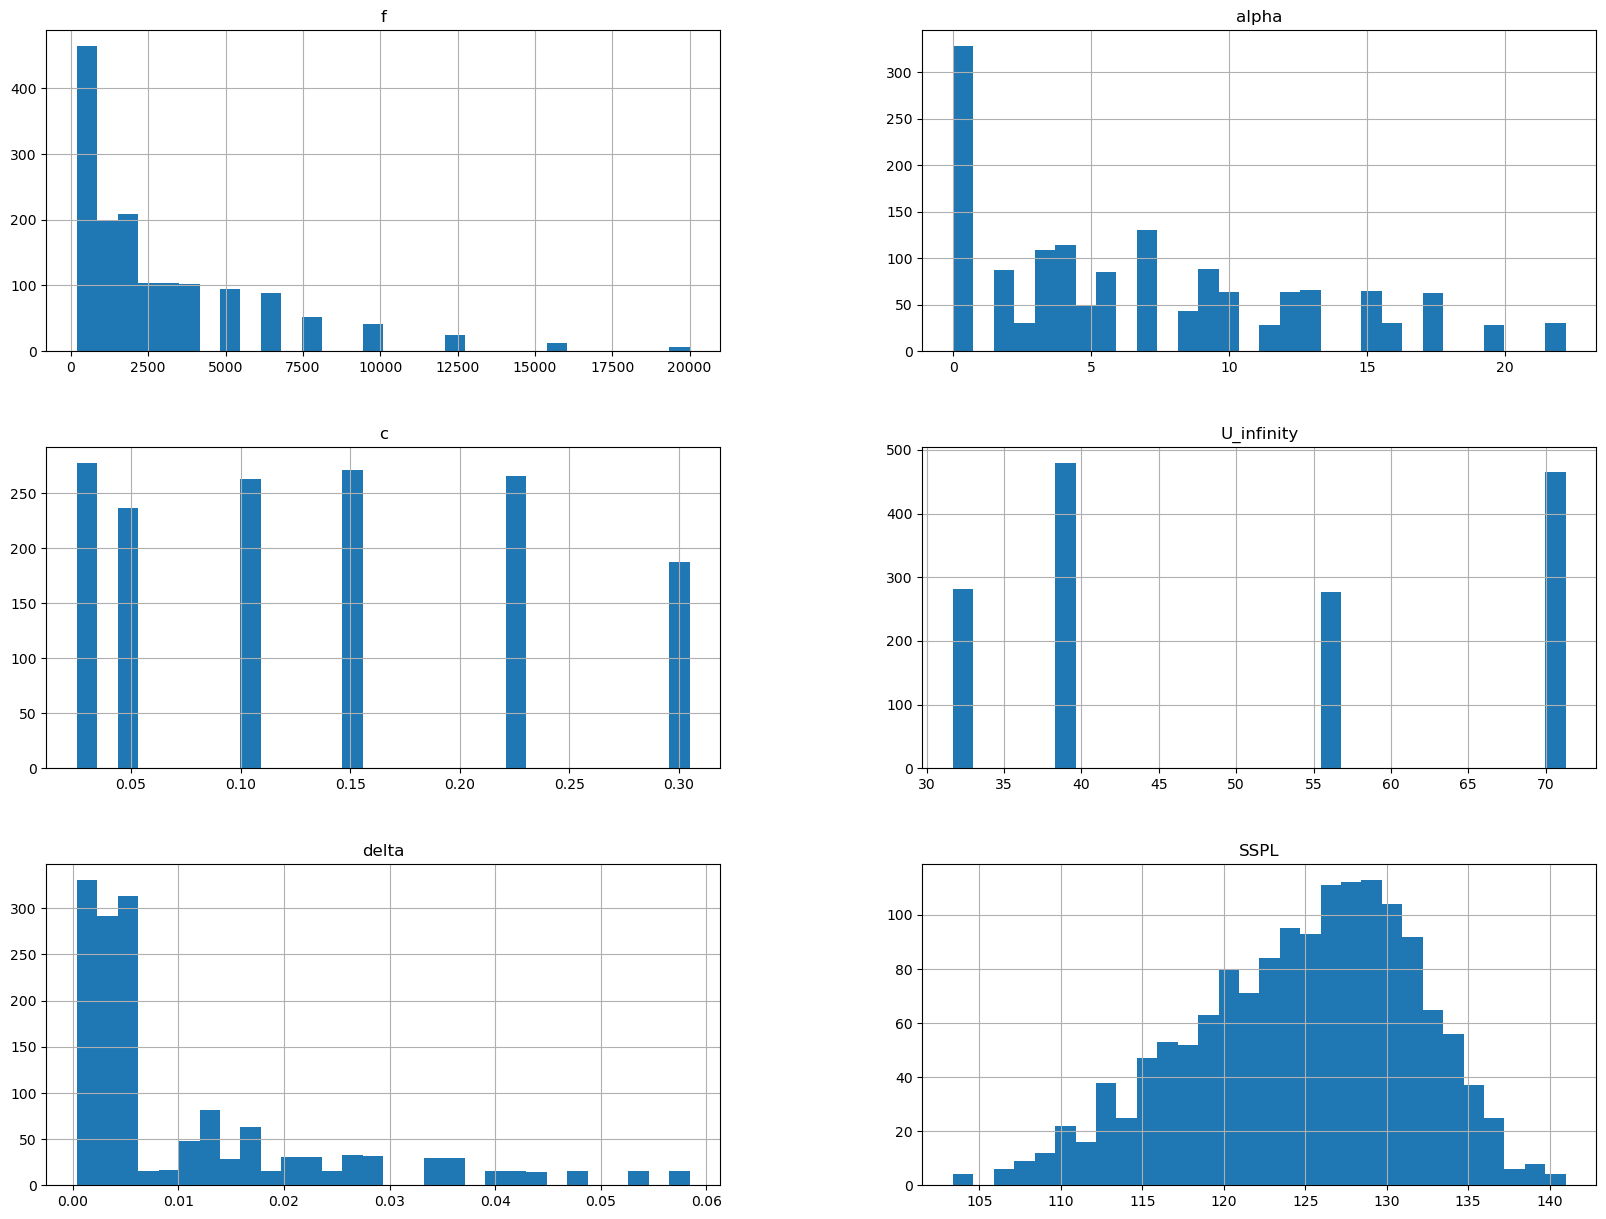

In [43]:
df.hist(bins=30, figsize=(20, 15))
#no majr outliers identified to perform any further clensing

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>], dtype=object)

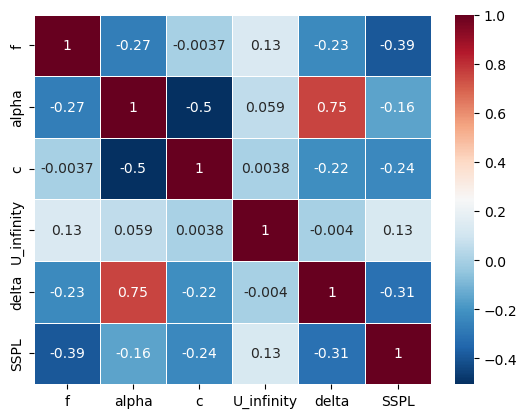

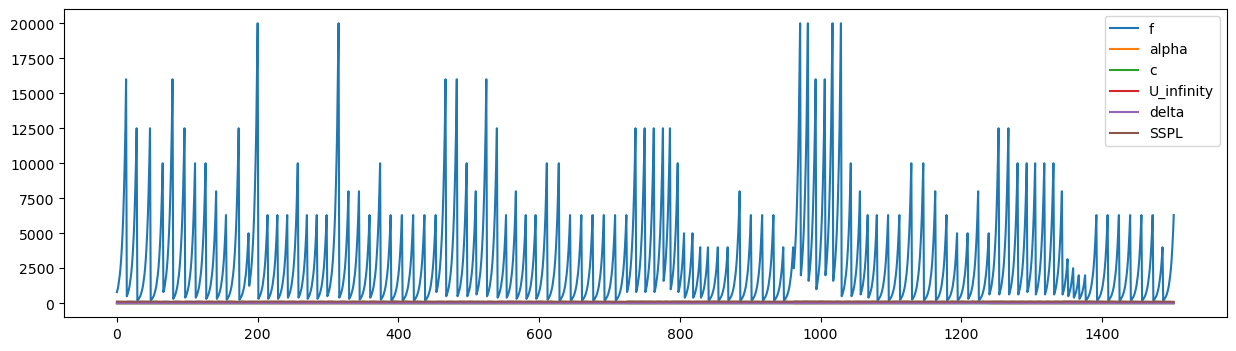

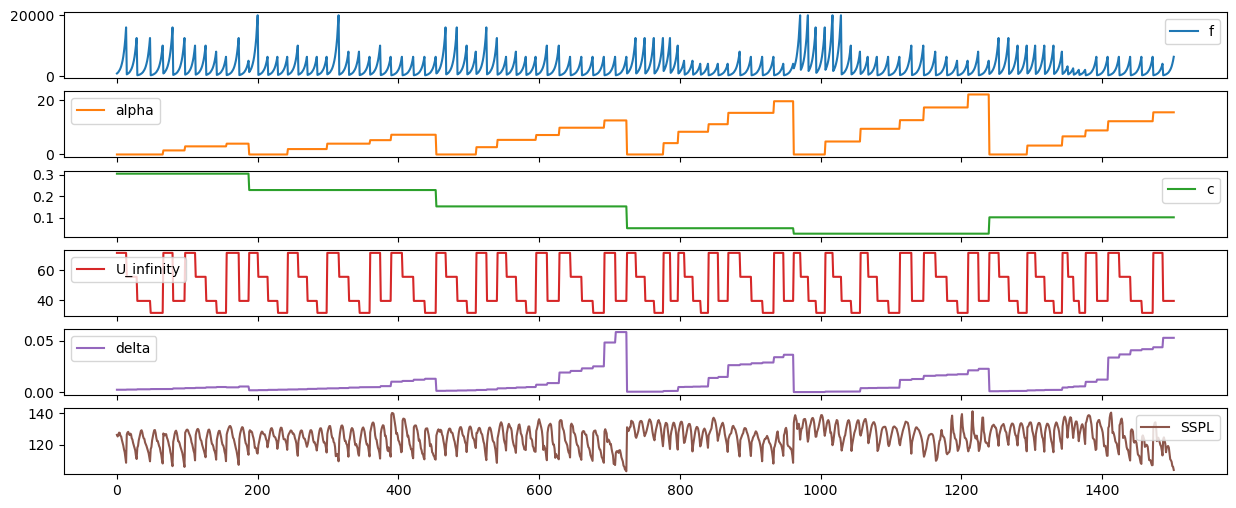

In [44]:
pearsoncorr = df.corr(method='pearson')
sns.heatmap(pearsoncorr, 
            xticklabels=pearsoncorr.columns,
            yticklabels=pearsoncorr.columns,
            cmap='RdBu_r',
            annot=True,
            linewidth=0.5)

df.plot(figsize=(15,4))
df.plot(subplots=True, figsize=(15,6))

In [45]:
data = df.copy() # input data 
X = data.iloc[:,:5]
y = data.iloc[:,5]
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True)

In [46]:
#scaling
scaler = StandardScaler()
scaler.fit(X_train_raw)
X_train = scaler.transform(X_train_raw)
X_test = scaler.transform(X_test_raw)
#X_all = scaler.transform(X)

In [66]:
# Convert to 2D PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype = torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)
#x_all = torch.tensor(X_all,dtype=torch.float32)

c:\Users\vborozniak\anaconda3\envs\gpu3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
c:\Users\vborozniak\anaconda3\envs\gpu3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until
c:\Users\vborozniak\anaconda3\envs\gpu3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.
c:\Users\vborozniak\anaconda3\envs\gpu

In [ ]:
%reset

In [13]:
model = nn.Sequential(
    nn.Linear(5, 24),
    nn.ReLU(),
    nn.Linear(24, 12),
    nn.ReLU(),
    nn.Linear(12, 6),
    nn.ReLU(),
    nn.Linear(6, 1)
)

In [14]:
# loss function and optimizer
loss_fn = MAPE()  # mean percentage error
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [15]:
n_epochs = 50   # number of epochs to run. Incorporate early stoppping!
batch_size = 10  # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)

In [16]:
best_mape = np.inf   # init to infinity
best_weights = None
history = []


In [17]:
for epoch in range(n_epochs):
    model.train()
    with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar: 
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(np.squeeze(y_pred), y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(mse=float(loss))
    # evaluate accuracy at end of each epoch
    model.eval()  #need to add training loss as well to plot both histories
    y_pred = model(X_test) 
    mape = loss_fn(np.squeeze(y_pred), y_test)
    mape = float(mape)
    history.append(mape)
    if mape < best_mape:
        best_mape = mape
        best_weights = copy.deepcopy(model.state_dict())

MAPE: 0.03


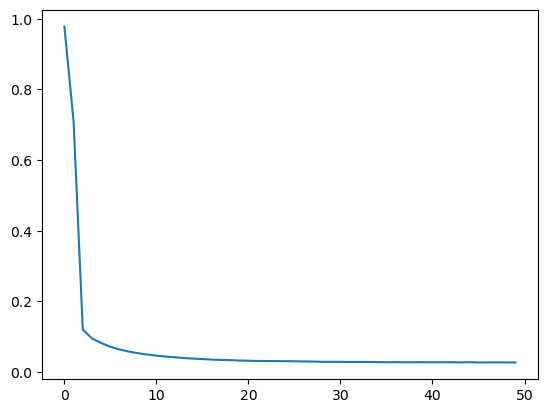

In [18]:
model.load_state_dict(best_weights)
print("MAPE: %.2f" % best_mape)
#print("RMSE: %.2f" % np.sqrt(best_mse))
plt.plot(history)
plt.show()

In [ ]:
#all_data_pred = model(x_all)

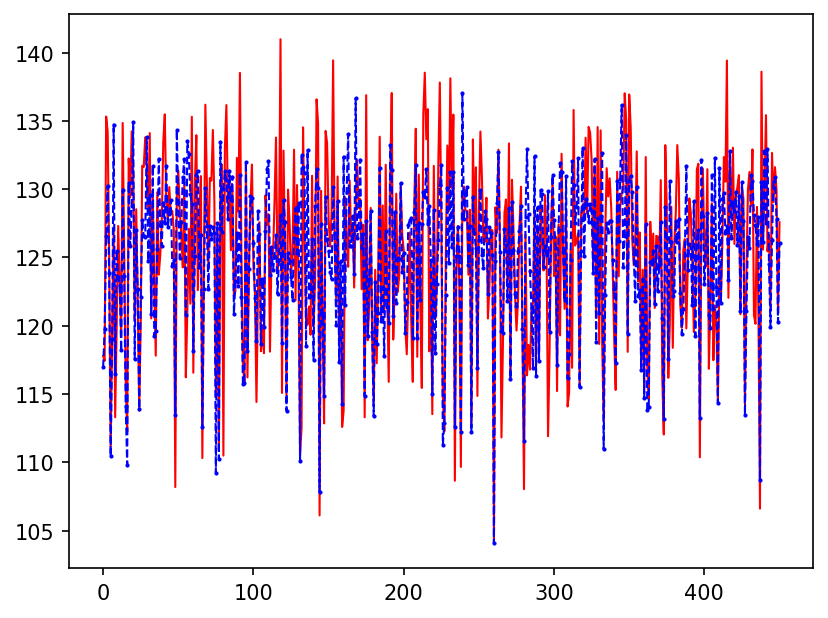

In [19]:
plt.figure(dpi=150)
plt.plot(y_test, color = 'red', label = 'Real',linewidth = 1)
plt.plot(y_pred.detach().numpy(), color = 'blue', label = 'Predicted',linestyle = 'dashed',marker = 'o',markersize = 1,linewidth = 1)

In [20]:
#check which input value is most significant to the output
from sklearn.metrics import mean_absolute_error
final_score = []
shuff_pred = []
for n,col in enumerate(X_test):
    # shuffle column
    shuff_test = X_test
    shuff_test[:,n] = np.random.permutation(shuff_test[:,n])  
    # compute score
    score = mean_absolute_error(y_test,model(torch.tensor(shuff_test, dtype=torch.float32)))
    shuff_pred.append((model(shuff_test).ravel()))
    final_score.append(score)
    
final_score = np.asarray(final_score)
plt.bar(range(X_train.shape[1]), ((final_score - MAE)/MAE)*100)
plt.xticks(range(X_train.shape[1]))
plt.show()
np.set_printoptions(False)

torch.tensor(X_test, dtype=torch.float32)

TypeError: can't assign a numpy.ndarray to a torch.FloatTensor

Epoch [1/50], Train Loss: 113.77405862247242, Val Loss: 97.56060028076172
Epoch [2/50], Train Loss: 92.23161091524013, Val Loss: 87.17381286621094
Epoch [3/50], Train Loss: 83.13781469008502, Val Loss: 79.19316864013672
Epoch [4/50], Train Loss: 76.44500956815831, Val Loss: 78.40504455566406
Epoch [5/50], Train Loss: 73.57104896096622, Val Loss: 74.49256134033203
Epoch [6/50], Train Loss: 67.68667804493623, Val Loss: 66.38400268554688
Epoch [7/50], Train Loss: 58.38096618652344, Val Loss: 59.77908706665039
Epoch [8/50], Train Loss: 55.70463270299575, Val Loss: 57.17639923095703
Epoch [9/50], Train Loss: 55.18389309153837, Val Loss: 57.261905670166016
Epoch [10/50], Train Loss: 54.83851309383617, Val Loss: 57.675960540771484
Epoch [11/50], Train Loss: 54.96708252850701, Val Loss: 57.5205192565918
Epoch [12/50], Train Loss: 54.6372979108025, Val Loss: 57.90095901489258
Epoch [13/50], Train Loss: 54.73268688426298, Val Loss: 57.70319366455078
Epoch [14/50], Train Loss: 55.03868708891027, 

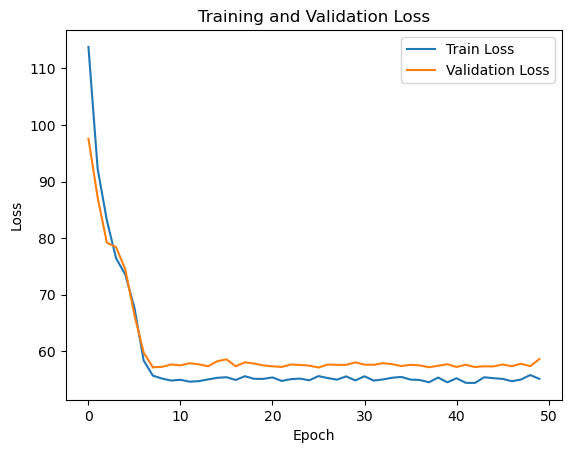

Feature Importance:
Input 1: 2.1331369876861572
Input 2: 0.28784942626953125
Input 3: 2.093273162841797
Input 4: 2.8951473236083984
Input 5: 6.068789482116699
Predicted: tensor([[ 45.9040],
        [169.8209],
        [112.3308],
        [134.5377],
        [  1.4967],
        [131.0506],
        [  2.0116],
        [109.7213],
        [131.5215],
        [ 28.7425],
        [126.1131],
        [ 34.5708],
        [100.6627],
        [117.2425],
        [130.5072],
        [  2.0858],
        [114.0325],
        [ 88.3978],
        [ 89.0909],
        [ 14.7750],
        [126.4189],
        [ 24.9161],
        [126.7152],
        [  2.7630],
        [133.0615],
        [ 32.1272],
        [112.4577],
        [ 90.7289],
        [109.2667],
        [ 15.1236],
        [173.8898],
        [ 14.0834],
        [  0.8699],
        [ 20.5553],
        [130.8107],
        [112.5414],
        [128.2416],
        [  6.1137],
        [135.2115],
        [ 15.0800],
        [ 82.2975],
        [ 

In [77]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# activation function - MAE
class MAEActivation(nn.Module):
    def __init__(self):
        super(MAEActivation, self).__init__()

    def forward(self, input):
        return input ** 2

        
        return x.float(), y.float()
# regression model -  5 input features, 1 output
class RegressionModel(nn.Module):
    def __init__(self):
        super(RegressionModel, self).__init__()
        self.linear = nn.Linear(5, 1)
        self.mae = MAEActivation()
        self.float()

    def forward(self, x):
        return self.mae(self.linear(x))

train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Create an instance of your regression model
model = RegressionModel()

# Define loss function and optimizer
loss_fn = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.1)

# Train the model and collect loss history
num_epochs = 50
train_loss_history = []
val_loss_history = []
for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    for inputs, targets in train_loader:
        # Forward pass
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_loss_history.append(train_loss)

    # Validation phase
    model.eval()
    with torch.no_grad():
        outputs = model(X_test)
        val_loss = loss_fn(outputs, y_test)
        val_loss_history.append(val_loss.item())

    # Print the loss after each epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss}, Val Loss: {val_loss.item()}")

# Calculate feature importance using gradients
feature_importance = torch.abs(model.linear.weight.grad).squeeze()

# Plot the history of loss
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Print the feature importance
print("Feature Importance:")
for i, importance in enumerate(feature_importance):
    print(f"Input {i+1}: {importance.item()}")

# Test the trained model
predicted = model(X_test)
print("Predicted:", predicted)

# Calculate MAE between predicted and test values
mae = torch.mean(torch.abs(predicted - y_test))
print("MAE:", mae.item())


In [70]:
mape = torch.mean(torch.abs((y_test - predicted) / y_test)) * 100
print("MAPE:", mape.item(), "%")

MAPE: 45.197776794433594 %


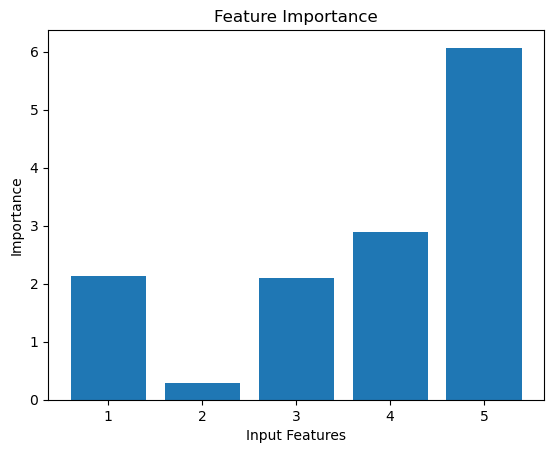

In [81]:
plt.bar(range(1, len(feature_importance) + 1), feature_importance)
plt.xlabel('Input Features')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.show()
